In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import math
import numpy as np
import datetime
from time import time
import seaborn as sns
from functools import reduce
from matplotlib import pyplot as plt
import pystan
from soccerlearn.features import *
from soccerlearn.models.bayesian_multiclass_classifier import BayesianMulticlassClassifier
    

SMALL_SIZE=8
MEDIUM_SIZE=SMALL_SIZE+2
BIGGER_SIZE=MEDIUM_SIZE+4

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', dpi=150)

In [3]:
data = pd.read_csv('../data/FeaturesComputer_La Liga_2000-07-01_2020-07-01.csv', parse_dates=['date'], index_col=['date']).dropna(subset=['result'])
#assert data.index.duplicated(keep=False).sum() == 0
print(data.shape)
data.head()

(5552, 135)


,local_team_id,season_id,h2h_draw_mean,h2h_games_played_sum,result,visitor_team_id,local_win_current_season,local_draw_current_season,local_goals_scored_current_season,local_goals_conceded_current_season,...,difference_in_goals_scored_current_season_lag_3,difference_in_points_current_season_lag_3,difference_in_goals_conceded_current_season_lag_3,difference_in_goals_scored_current_season_lag_4,difference_in_points_current_season_lag_4,difference_in_goals_conceded_current_season_lag_4,difference_in_goals_scored_current_season_lag_5,difference_in_points_current_season_lag_5,difference_in_goals_conceded_current_season_lag_5,difference_in_id
date,,,,,,,,,,,,,,,,,,,,,
2005-08-28,36,2052,NaN,0.0,win,126,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-90
2005-09-18,36,2052,NaN,0.0,loss,9818,2.0,0.0,5.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9782
2005-09-25,36,2052,NaN,0.0,win,676,3.0,0.0,7.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-640
2005-10-23,36,2052,NaN,0.0,win,528,4.0,1.0,10.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-492
2005-11-06,36,2052,NaN,0.0,win,2975,5.0,2.0,12.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2939


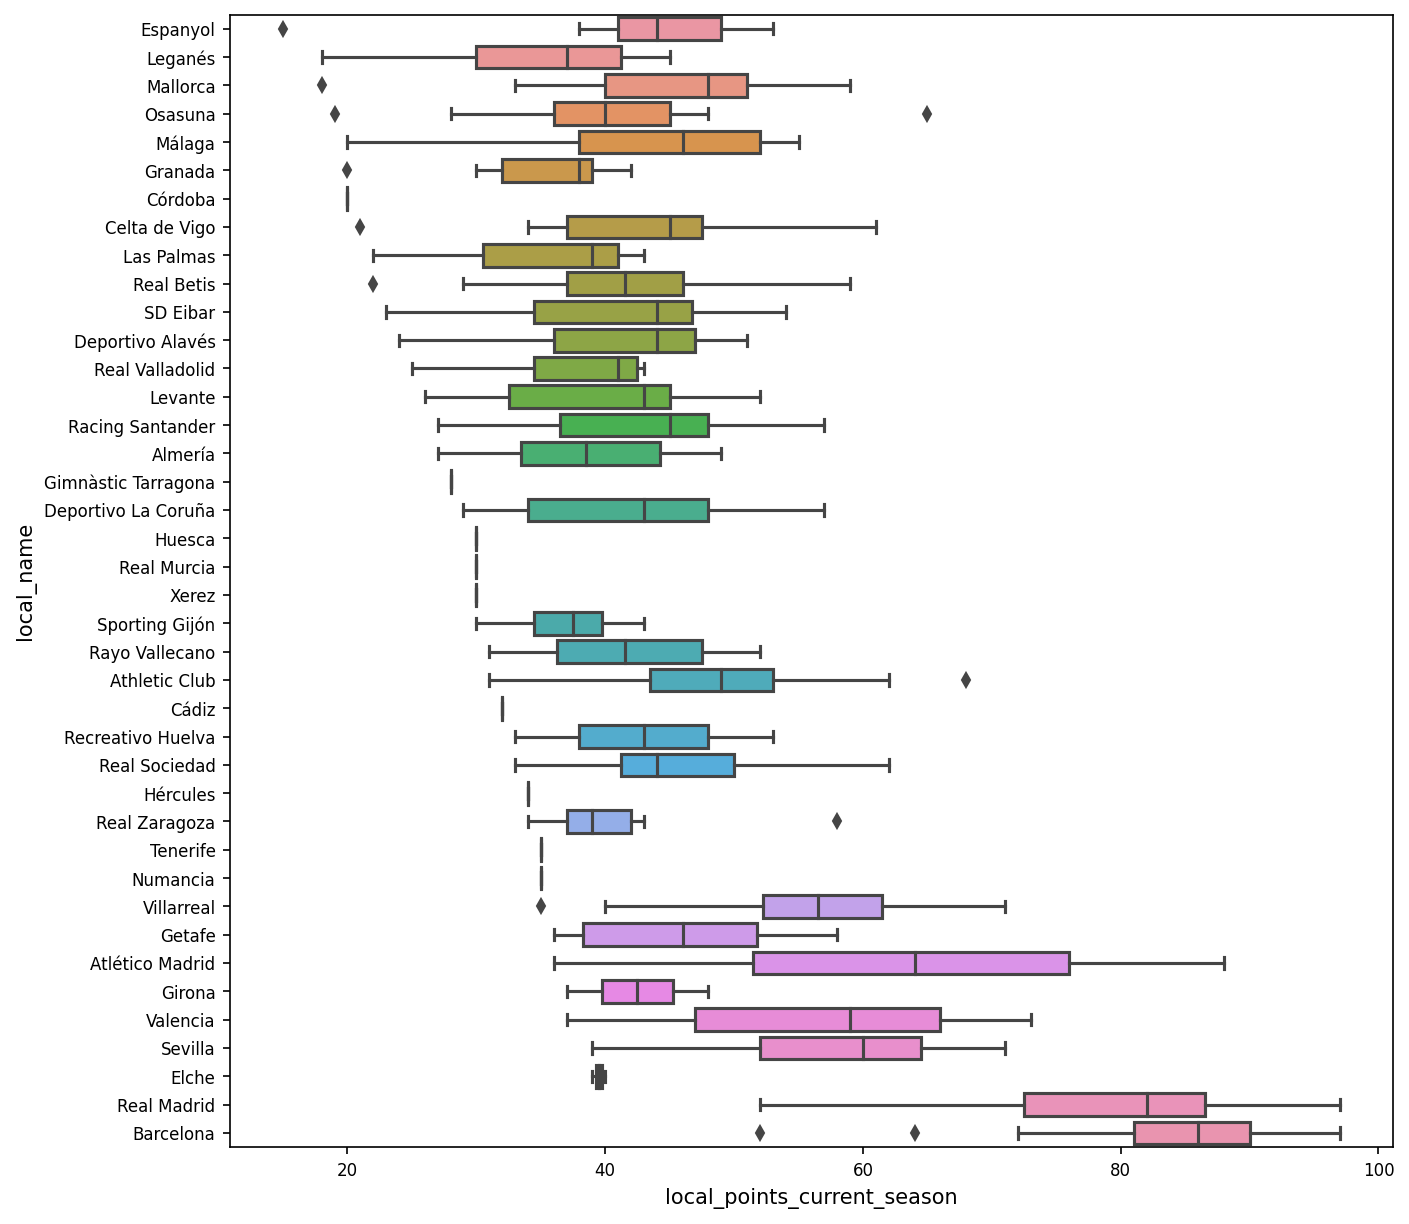

In [4]:
fig, ax = plt.subplots(figsize=(10, 10))
average_points_end_season = data.groupby(['local_name', 'season_id'])['local_points_current_season'].max().sort_values().reset_index()
ax = sns.boxplot(x='local_points_current_season', y='local_name', data=average_points_end_season, orient='h', ax=ax)

In [5]:
def add_interactive_effects(data, pairs_of_columns):
    for column_a, column_b in pairs_of_columns:
        data[f'{column_a}_x_{column_b}'] = data[column_a] * data[column_b]
    
    return data

def target_to_numeric(data):
    data['result'] = data['result'].map({'win': 3, 'draw': 2, 'loss': 1}).astype(int)
    return data

data = add_interactive_effects(data, [('difference_in_points_current_season', 'local_games_played_current_season')])
data = target_to_numeric(data)

In [8]:
train_end_date = '2020-05-01'
test_start_date = train_end_date

feature_names = [
    'difference_in_points_current_season',
    #'local_games_played_current_season',
    #'difference_in_points_current_season_x_local_games_played_current_season',
]
target_name = 'result'

features_train = data[feature_names].loc[:train_end_date]
target_train = data[target_name].loc[:train_end_date]
features_test = data[feature_names].loc[test_start_date:]
target_test = data[target_name].loc[test_start_date:]
target_train.head()

date
2005-08-28    3
2005-09-18    1
2005-09-25    3
2005-10-23    3
2005-11-06    3
Name: result, dtype: int64

In [ ]:
model = BayesianMulticlassClassifier(n_jobs=-1)
model.fit(features_train, target_train)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_101df49be09865b859180407bb488be8 NOW.
INFO:pystan:OS: darwin, Python: 3.8.5 (default, Jul 21 2020, 10:48:26) 
[Clang 11.0.3 (clang-1103.0.32.62)], Cython 0.29.21


Fitting model:  
            data {
                int<lower=0> N;
                int<lower=0> P;
                matrix[N, P] X;
                int<lower=0> K;
                int<lower=0,upper=K> y[N];
            }
            parameters {
                matrix[P, K] coefficients;
            }
            model {
                matrix[N, K] fitted_values = X * coefficients;
                for (n in 1:N)
                    y[n] ~ categorical_logit(fitted_values[n]');
            }
        
Compiling /var/folders/rw/3pwkskgj52s3q5682nqhv3500000gp/T/pystan_nhc_x3nn/stanfit4anon_model_101df49be09865b859180407bb488be8_2348443808382438609.pyx because it changed.
[1/1] Cythonizing /var/folders/rw/3pwkskgj52s3q5682nqhv3500000gp/T/pystan_nhc_x3nn/stanfit4anon_model_101df49be09865b859180407bb488be8_2348443808382438609.pyx
building 'stanfit4anon_model_101df49be09865b859180407bb488be8_2348443808382438609' extension
creating /var/folders/rw/3pwkskgj52s3q5682nqhv3500000gp/T/pystan_nhc_x3n

In [300]:
model.model.extract()

AttributeError: 'BayesianMulticlassClassifier' object has no attribute 'model'

In [295]:
predictions = model.predict(features_test)

ModelNotTrainedError: 

In [ ]:
model.parameters.plot(figsize=(20, 5))

array([[<AxesSubplot:title={'center':'log_probability'}>]], dtype=object)

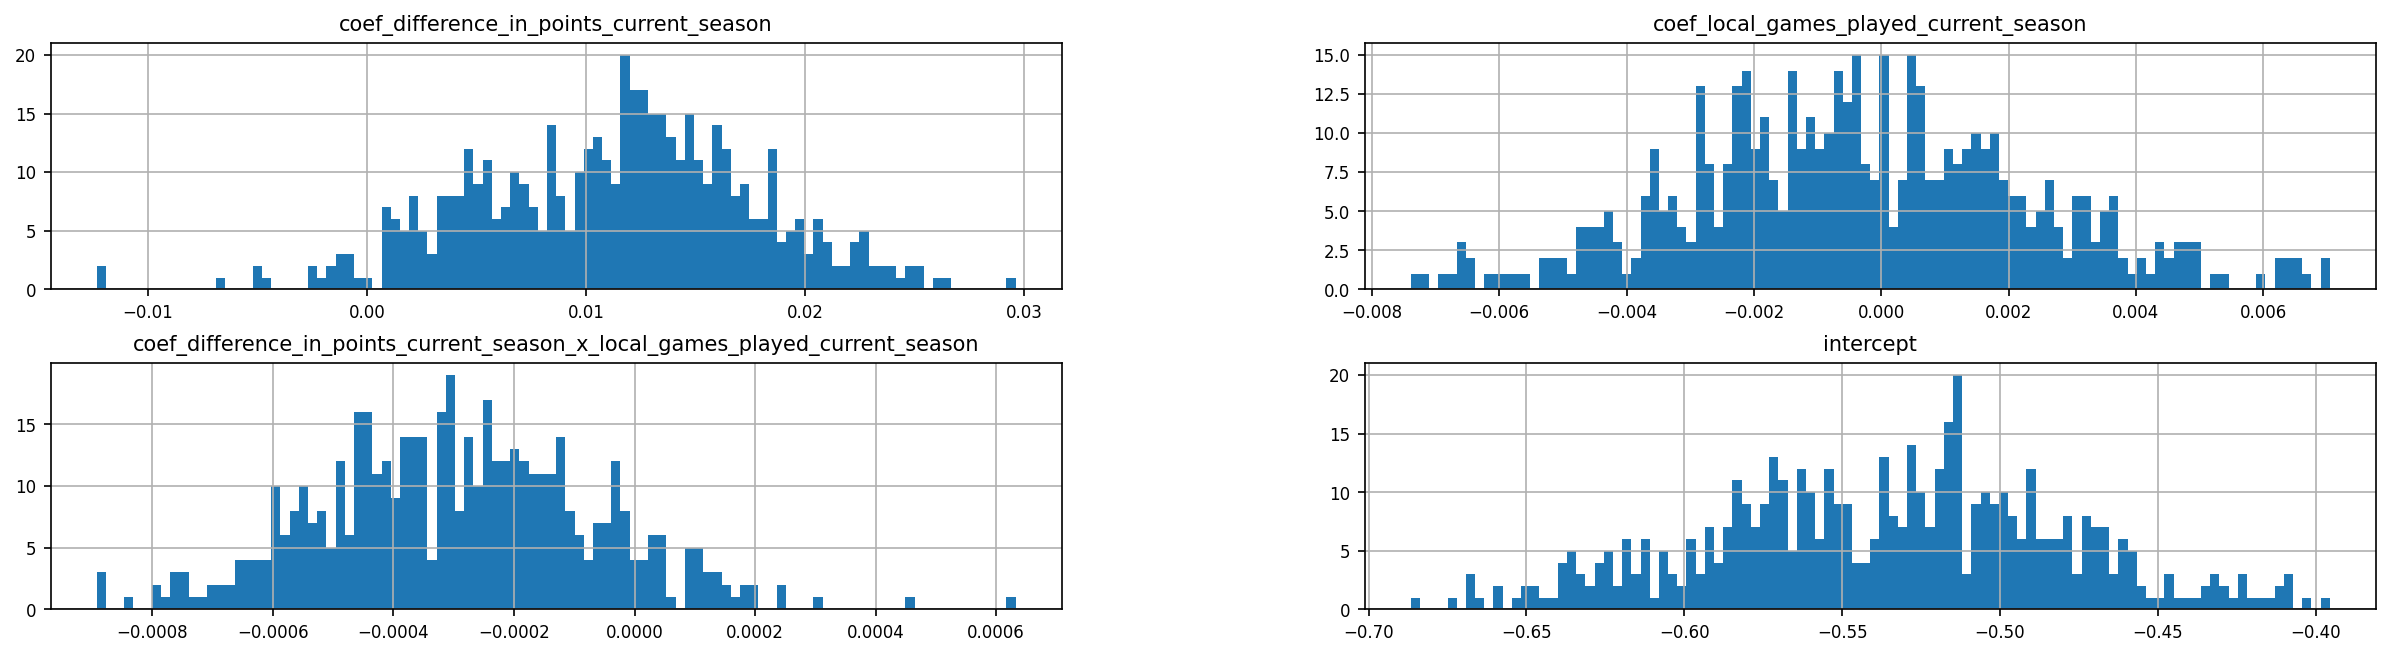

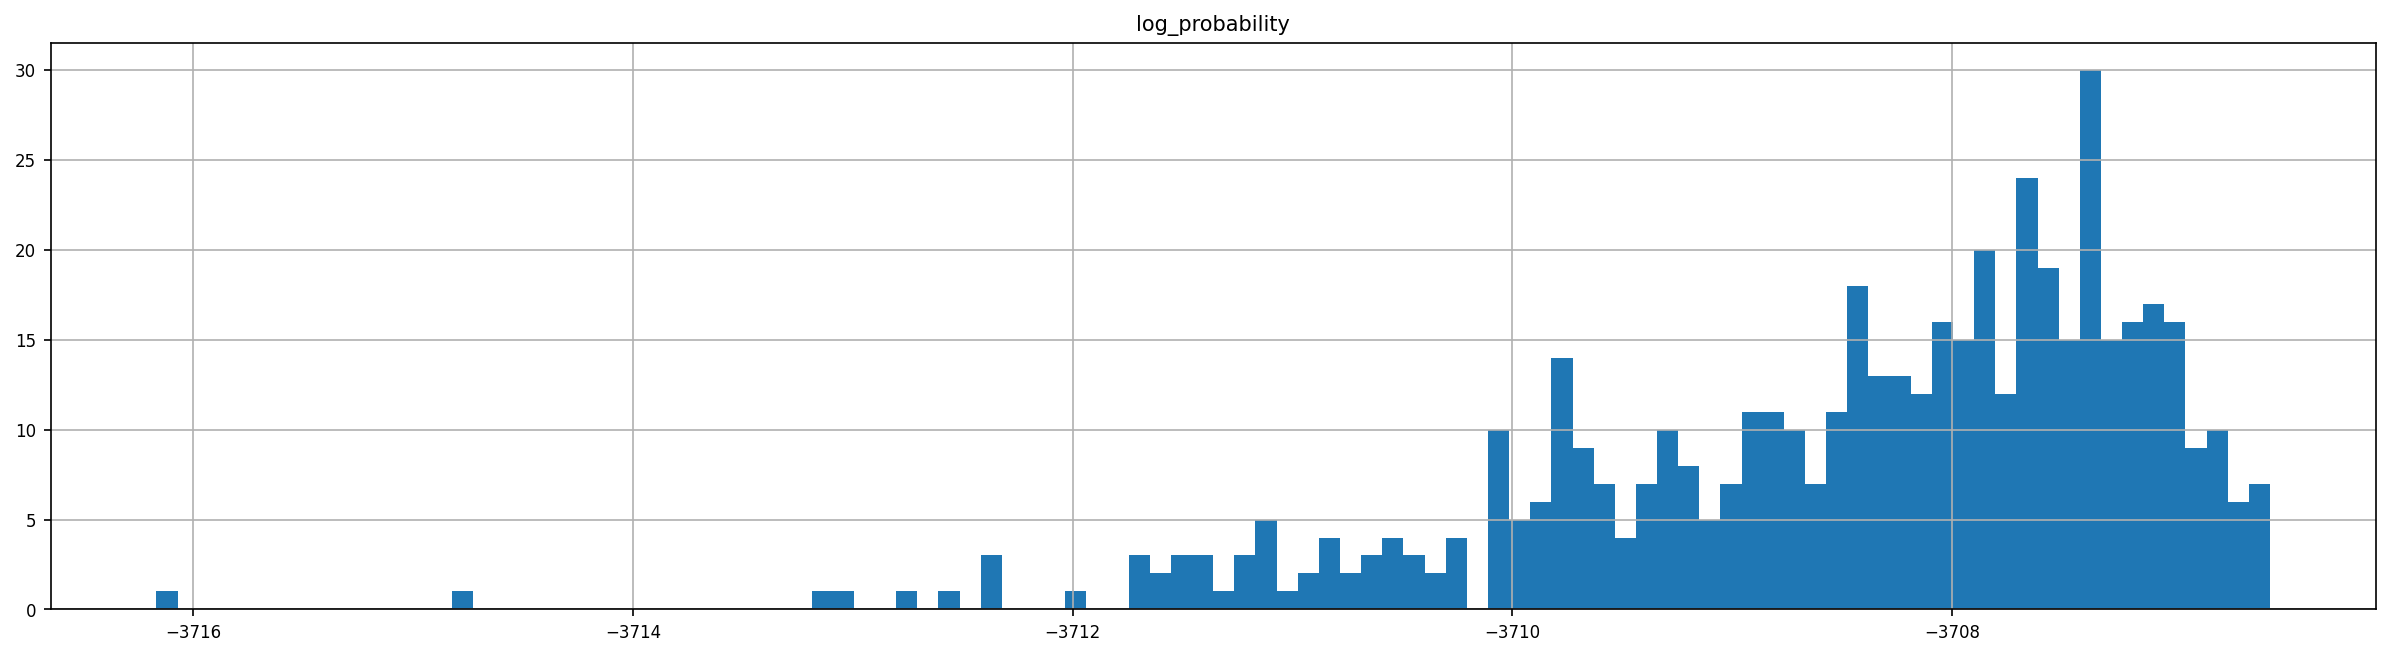

In [214]:
model.parameters.hist(figsize=(20, 5), bins=100)
model.log_probability.hist(figsize=(20, 5), bins=100)

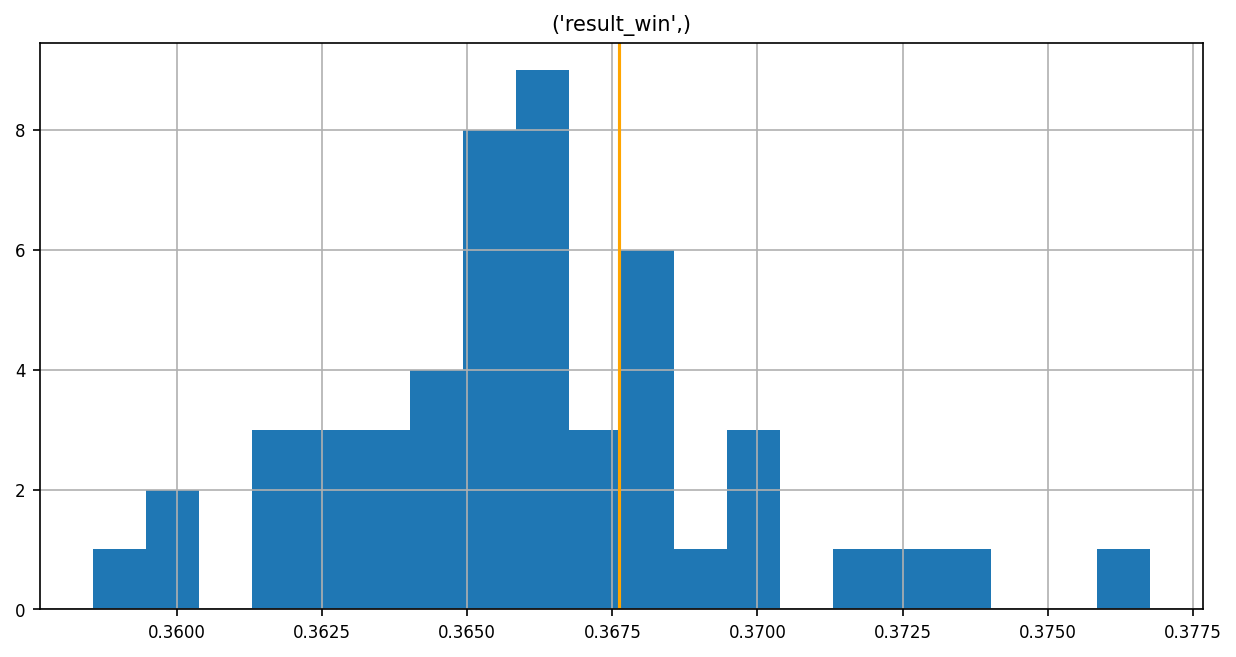

In [217]:
ax = predictions.hist(figsize=(10, 5), bins=20)
plt.axvline(target_train.mean()['result_win'], color='orange')

In [172]:
np.mean((target_test - predictions['result_win'])**2)

0.1329106966781949

<AxesSubplot:>

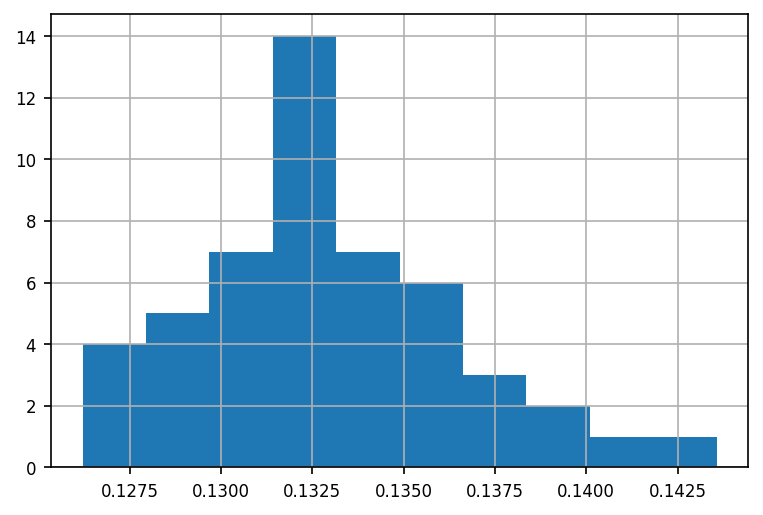

In [173]:
((target_test > 0.5 - predictions['result_win'])**2).hist()

In [245]:
data_to_plot = []
min_games_played, max_games_played = 10, 30#features_train['local_games_played_current_season'].min(), features_train['local_games_played_current_season'].max()
for diff in range(int(features_train['difference_in_points_current_season'].min()), int(features_train['difference_in_points_current_season'].max())):
    data_to_plot.append({'local_games_played_current_season': min_games_played, 'difference_in_points_current_season': diff, 'difference_in_points_current_season_x_local_games_played_current_season': min_games_played * diff})
    data_to_plot.append({'local_games_played_current_season': max_games_played, 'difference_in_points_current_season': diff, 'difference_in_points_current_season_x_local_games_played_current_season': max_games_played * diff})
    
data_to_plot = pd.DataFrame(data_to_plot)
data_to_plot['prediction'] = model.predict(data_to_plot)
data_to_plot.head()


,local_games_played_current_season,difference_in_points_current_season,difference_in_points_current_season_x_local_games_played_current_season,prediction
0,10,-64,-640,0.255050
1,30,-64,-1920,0.331414
2,10,-63,-630,0.256632
3,30,-63,-1890,0.331951
4,10,-62,-620,0.258221


In [246]:
features_train.head()

,difference_in_points_current_season,local_games_played_current_season,difference_in_points_current_season_x_local_games_played_current_season
date,,,
2005-08-28,0.0,0.0,0.0
2005-09-18,6.0,2.0,12.0
2005-09-25,4.0,4.0,16.0
2005-10-23,6.0,7.0,42.0
2005-11-06,9.0,10.0,90.0


/Users/javiermas/repos/soccer-predictions/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


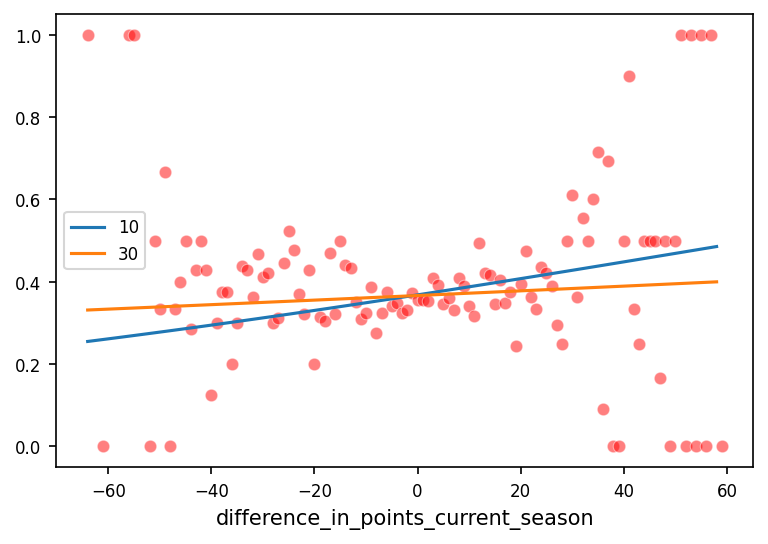

In [247]:
data_to_plot.set_index('difference_in_points_current_season').groupby('local_games_played_current_season')['prediction'].plot()
average_results = target_train.groupby(features_train['difference_in_points_current_season'])['result_win'].mean()
sns.scatterplot(average_results.index, average_results.values, y_jitter=0.1, alpha=0.5, color='r')
plt.legend()

In [226]:
predictive_function

,result_win
0,0.221510
1,0.364989
2,0.223457
3,0.365004
4,0.225416
...,...
241,0.366850
242,0.526242
243,0.366865
244,0.529047
